# 05 AdvancedCNN Augmentation

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


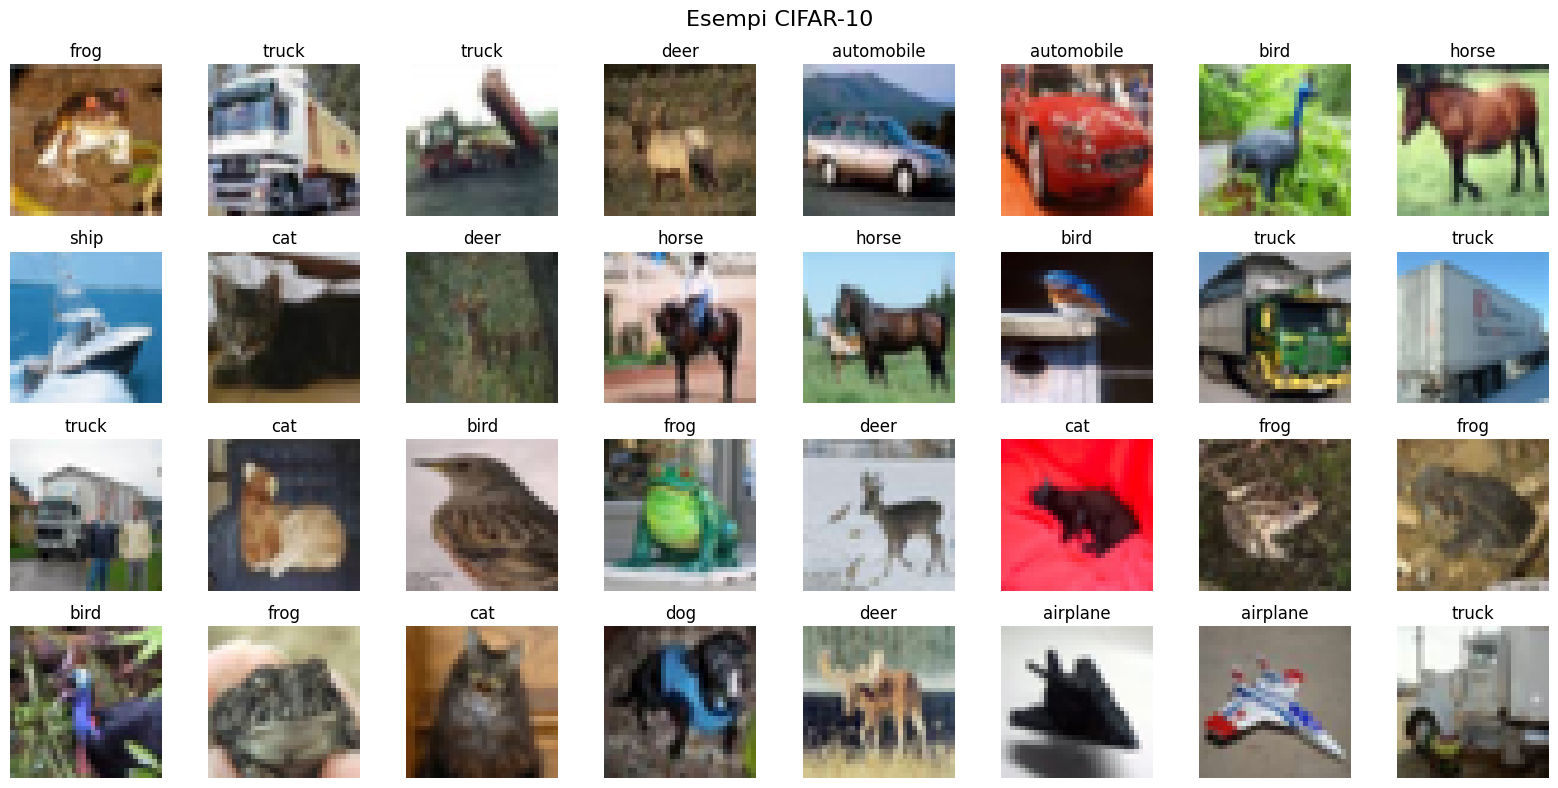

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

In [2]:
# Normalizzazione a [0,1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Converti in tensori PyTorch (NCHW format)
X_train_tensor = torch.from_numpy(X_train_norm).permute(0, 3, 1, 2)  # NHWC -> NCHW
X_test_tensor = torch.from_numpy(X_test_norm).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

print("Shape dopo preprocessing:")
print(f"  X_train tensor: {X_train_tensor.shape}")
print(f"  y_train tensor: {y_train_tensor.shape}")
print(f"Range valori: [{X_train_tensor.min():.2f}, {X_train_tensor.max():.2f}]")

Shape dopo preprocessing:
  X_train tensor: torch.Size([50000, 3, 32, 32])
  y_train tensor: torch.Size([50000])
Range valori: [0.00, 1.00]


In [ ]:
def train_model(model, train_loader, val_loader, epochs=5,
                lr=0.001, patience=5, patience_lr=3, device=device):
    """
    Training loop generico PyTorch con early stopping e ReduceLROnPlateau.
    Restituisce un dizionario con history (come Keras).
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience_lr, min_lr=1e-7
    )

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

In [ ]:
def evaluate_model(model, X_tensor, y_tensor, device=device):
    """Evaluate model and return loss, accuracy, predictions."""
    model.eval()
    test_dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.append(predicted.cpu())
            all_probs.append(probs.cpu())

    test_loss = test_loss / total
    test_acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return test_loss, test_acc, all_preds, all_probs

### 3.4 Data Augmentation per migliorare performance

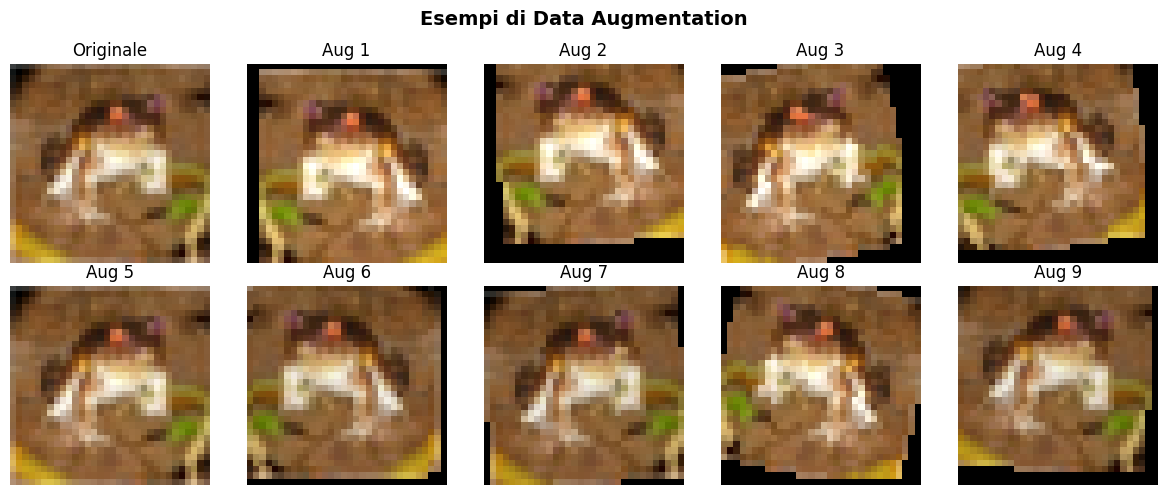

In [8]:
# Data Augmentation con torchvision transforms
from torchvision import transforms
from PIL import Image

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
])

# Visualizzazione augmentation
sample_img = X_train[0]  # HWC uint8
sample_pil = Image.fromarray(sample_img)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

axes[0].imshow(sample_img)
axes[0].set_title('Originale')
axes[0].axis('off')

for i in range(1, 10):
    aug_tensor = augmentation_transform(sample_pil)
    # Convert CHW tensor back to HWC numpy for display
    aug_img = aug_tensor.permute(1, 2, 0).numpy()
    axes[i].imshow(aug_img)
    axes[i].set_title(f'Aug {i}')
    axes[i].axis('off')

plt.suptitle(
    'Esempi di Data Augmentation',
    fontsize=14, fontweight='bold'
)
plt.tight_layout()
plt.show()

### 3.5 CNN Avanzata con Data Augmentation

In [9]:
class AdvancedCNN(nn.Module):
    """
    CNN avanzata con piu' layer e regolarizzazione.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Blocco 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            # Blocco 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            # Blocco 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model_advanced = AdvancedCNN().to(device)
total_params_adv = sum(p.numel() for p in model_advanced.parameters())
print(f"Parametri totali: {total_params_adv:,}")

# FIX: Proper validation split (not using test set)
from sklearn.model_selection import train_test_split as sk_split

# Split training data into train/val
indices_all = np.arange(len(X_train_norm))
idx_tr_adv, idx_val_adv = sk_split(
    indices_all, test_size=0.2, random_state=42
)

X_tr_adv_np = X_train_norm[idx_tr_adv]
y_tr_adv_np = y_train[idx_tr_adv]
X_val_adv_np = X_train_norm[idx_val_adv]
y_val_adv_np = y_train[idx_val_adv]

# Create augmented dataset using torchvision transforms
train_augment_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Custom dataset for augmentation
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images_np, labels_np, transform=None):
        """images_np: NHWC float32 [0,1], labels_np: int array"""
        self.images = images_np
        self.labels = labels_np
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # Convert to PIL for transforms
        img_uint8 = (img * 255).astype(np.uint8)
        pil_img = Image.fromarray(img_uint8)
        if self.transform:
            img_tensor = self.transform(pil_img)
        else:
            img_tensor = transforms.ToTensor()(pil_img)
        return img_tensor, torch.tensor(label, dtype=torch.long)

train_aug_dataset = AugmentedDataset(X_tr_adv_np, y_tr_adv_np, train_augment_transform)
val_adv_tensor_x = torch.from_numpy(X_val_adv_np).permute(0, 3, 1, 2).float()
val_adv_tensor_y = torch.from_numpy(y_val_adv_np).long()
val_adv_dataset = TensorDataset(val_adv_tensor_x, val_adv_tensor_y)

train_loader_adv = DataLoader(train_aug_dataset, batch_size=128, shuffle=True)
val_loader_adv = DataLoader(val_adv_dataset, batch_size=128, shuffle=False)

# Training with augmentation (with weight caching)
history_advanced = load_or_train(
    model_advanced,
    lambda: train_model(
        model_advanced, train_loader_adv, val_loader_adv,
        epochs=5, lr=0.001, patience=5, patience_lr=3
    ),
    'nb06_advanced_cnn.pt',
    device=device
)

# Risultati
test_loss_adv, test_acc_adv, _, _ = evaluate_model(
    model_advanced, X_test_tensor, y_test_tensor
)
print(f"\nCNN Avanzata - Test Accuracy: {test_acc_adv:.4f}")


Parametri totali: 3,251,018
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb06_advanced_cnn.pt

CNN Avanzata - Test Accuracy: 0.9009
